<div class="alert alert-block alert-success">

<a class="anchor" id="1st-bullet">    </a>
## 1. Import necessary libraries & Data Preprocessed and Functions
    

    
</div>

In [136]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.patches import RegularPolygon
import matplotlib.colors as mpl_colors
import matplotlib.colorbar as colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

from math import ceil
from collections import Counter
from sklearn.metrics import pairwise_distances

from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score
from scipy.stats import zscore
from sklearn.cluster import KMeans, AgglomerativeClustering,MeanShift, estimate_bandwidth, DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')
sns.set_style(style="whitegrid")


In [137]:
# import data preprocessed
df_preprocessed = pd.read_csv("data_preprocessed.csv")
df_preprocessed.head(2)

,customer_id,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,...,HR_afternoon,HR_evening,Weekdays,Weekend,total_spent,total_orders,avg_spending_per_order,chain_order_ratio,preferred_cui,preferred_cui_type
0,1b8f824d5e,2360,18.0,2,5,1,0.0,1,DELIVERY,DIGI,...,2,0.0,0,2,28.88,2,14.440,0.5,CUI_Indian,Asian_Cuisine
1,5d272b9dcb,8670,17.0,2,2,2,0.0,1,DISCOUNT,DIGI,...,0,0.0,0,2,19.21,2,9.605,1.0,CUI_American,Western_Cuisine


In [138]:
df_preprocessed.drop(columns="customer_id", inplace=True) # it´s easier to have customers id as 0,1,2 for clusters.
df_preprocessed.head(1)

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,...,HR_afternoon,HR_evening,Weekdays,Weekend,total_spent,total_orders,avg_spending_per_order,chain_order_ratio,preferred_cui,preferred_cui_type
0,2360,18.0,2,5,1,0.0,1,DELIVERY,DIGI,0.0,...,2,0.0,0,2,28.88,2,14.44,0.5,CUI_Indian,Asian_Cuisine


<a class="anchor" id="3rd-bullet">

### Functions:
</a>

In [139]:


# Calculate R2 and see the score
def get_sst(df): 
    """
    Calculates the sum of squared distances of each point to the mean of the points
    """
    return np.sum(df.var() * (df.count() - 1))

def get_r2_score(df, labels):
    """
    Calculates the proportion of variance explained by the clustering (r2)
    """
    sst = get_sst(df)
    ssw = np.sum(df.groupby(labels).apply(get_sst))
    ssb = sst - ssw
    return ssb / sst

# Hierarchical Clustering
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, metric="euclidean"):
    sst = get_sst(df)
    
    r2 = []  
    for i in range(min_nclus, max_nclus+1):
        cluster = AgglomerativeClustering(n_clusters=i, metric=metric, linkage=link_method)
        hclabels = cluster.fit_predict(df) 
        df_concat = df.copy()
        df_concat['labels'] = hclabels
        r2.append(get_r2_score(df_concat, 'labels'))
        
    return np.array(r2)

def hierarchical_clustering_methods_nclust_analysis(dataframe, hc_methods, max_nclus, metric="euclidean"):
    r2_hc_methods = np.vstack(
        [
            get_r2_hc(dataframe, link, max_nclus, metric=metric)
            for link in hc_methods
        ]
    ).T

    r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

    sns.set()
    fig = plt.figure(figsize=(11, 5))
    sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)
    fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
    plt.legend(title="HC methods", title_fontsize=11)
    plt.xticks(range(1, max_nclus + 1))
    plt.xlabel("Number of clusters", fontsize=13)
    plt.ylabel("R2 metric", fontsize=13)
    plt.show()

# Plot dendrogram
def plot_dendrogram(dataframe, y_threshold, linkage="ward", metric='euclidean'):
    hclust = AgglomerativeClustering(linkage=linkage, metric=metric, distance_threshold=0, n_clusters=None)
    hclust.fit(dataframe)

    counts = np.zeros(hclust.children_.shape[0])
    n_samples = len(hclust.labels_)

    for i, merge in enumerate(hclust.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack(
        [hclust.children_, hclust.distances_, counts]
    ).astype(float)

    sns.set()
    fig = plt.figure(figsize=(11, 5))
    dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
    plt.hlines(y_threshold, 0, plt.gca().get_xlim()[1], colors="r", linestyles="dashed")
    plt.title(f'Hierarchical Clustering - {linkage} | Dendrogram', fontsize=21)
    plt.xlabel('Number of points in node (or index of point if no parenthesis)')
    plt.ylabel(f'{metric} Distance', fontsize=13)
    plt.show()

# K-Means
def plot_inertia_silhouette_scores(dataframe, min_clust, max_clust):
    range_clusters = range(min_clust, max_clust + 1)

    inertia = []
    avg_silhouette = []
    for n_clus in range_clusters:
        kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
        cluster_labels = kmclust.fit_predict(dataframe)
        inertia.append(kmclust.inertia_)
        silhouette_avg = silhouette_score(dataframe, cluster_labels)
        avg_silhouette.append(silhouette_avg)

    f, (ax1, ax2) = plt.subplots(1, 2)
    f.set_size_inches(18.5, 8)
    
    ax1.plot(range_clusters, inertia, marker='o')
    ax1.set_title('Inertia plot over clusters')
    ax1.set_ylabel("Inertia: SSw")
    ax1.set_xlabel("Number of clusters")
    ax1.set_xticks(np.arange(min_clust, max_clust + 1, 1))
    
    ax2.plot(range_clusters, avg_silhouette, marker='o')
    ax2.set_title('Average silhouette plot over clusters')
    ax2.set_ylabel("Average silhouette")
    ax2.set_xlabel("Number of clusters")
    ax2.set_xticks(np.arange(min_clust, max_clust + 1, 1))
    
    plt.show()

# Comparison of R2 scores
def plot_models_r2_nclust(models_dict, lower_lim):
    scores = []
    n_clusters = []
    for modelName, modelDataframe in models_dict.items():
        scores.append(get_r2_score(modelDataframe, 'labels'))
        n_clusters.append(len(np.unique(modelDataframe['labels'])))
        
    sns.set()
    f, (ax1, ax2) = plt.subplots(1, 2)
    f.set_size_inches(18.5, 12.5)
    
    x = np.arange(len(scores))  # the label locations
    
    width = 0.20  # the width of the bars
    ax1.set_facecolor("white")
    ax1.bar(x - width/2, scores, width, color="#4A7A89")
    ax1.set_ylim(lower_lim, 1.0)
    ax1.set_ylabel('Scores', fontsize=14)
    ax1.set_title('R-Squared score by Model', fontsize=16)
    ax1.set_xticks(x)
    ax1.set_xticklabels(models_dict.keys(), fontsize=14)
    
    ax2.set_facecolor("white")
    ax2.bar(x - width/2, n_clusters, width, color="#4A7A89")
    ax2.set_ylabel('Number of Clusters', fontsize=14)
    ax2.set_title('Number of Clusters by Model', fontsize=16)
    ax2.set_xticks(x)
    ax2.set_xticklabels(models_dict.keys(), fontsize=14)
    plt.show()

# Cluster visualization
def plot_2dClusters(df_reduced, models_dict): 
    f, ax = plt.subplots(2, 3, sharey=True)
    f.set_size_inches(18.5, 12.5)
    xlabel = df_reduced.columns[0]
    ylabel = df_reduced.columns[1]
    j = 0
    i = 0
    for modelName, modelDataframe in models_dict.items():
        labels = modelDataframe['labels']
        if j == 3:
            i += 1
            j = 0
        ax[i][j].set_title(modelName, fontsize=15)
        ax[i][j].set_xlabel(xlabel, fontsize=15)
        ax[i][j].set_ylabel(ylabel, fontsize=15)
        ax[i][j].scatter(df_reduced.iloc[:, 0], df_reduced.iloc[:, 1], c=labels, cmap='tab20', s=2)
        j += 1
    plt.show()

# Access feature importance and reclassifying outliers
def get_ss_var(df):
    ss = df.var() * (df.count() - 1)
    return ss  # return sum of sum of squares of each df variable.

def get_r2_variables(df, labels_name):
    df_temp = df.copy()
    df_temp.drop(labels_name, axis=1, inplace=True)
    
    sst = get_ss_var(df_temp)
    ssw_labels = np.sum(df.groupby(labels_name).apply(get_ss_var))
    return 1 - ssw_labels / sst


<div class="alert alert-block alert-success">

<a class="anchor" id="1st-bullet">    </a>
## 2. Kmeans and HC different perspectives:
    

    
</div>

<a class="anchor" id="3rd-bullet">

### Scale Data and define some functions and perspetives:    
</a>

In [140]:
df_preprocessed.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes',
       'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'Sunday', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'HR_0',
       'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9',
       'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17',
       'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'age_category',
       'Western_Cuisine', 'Asian_Cuisine', 'Complementary_Cuisine',
       'Other_Cuisines', 'chain_frequency', 'HR_breakfast', 'HR_lunch_dinner',
       'HR_afternoon', 'HR_evening', 'Weekdays', 'Weekend', 'total_spent',
       'total_orders',

In [141]:
value_perspetive = ['total_spent', 'avg_spending_per_order', 'last_order']
behaviour_features = ['Weekend','Weekdays', 'chain_order_ratio', 'HR_breakfast', 'HR_lunch_dinner', 'HR_afternoon', 'HR_evening']
preference_features = ['Western_Cuisine', 'Asian_Cuisine', 'Complementary_Cuisine', 'Other_Cuisines']

**After having final clusters we will associate categorical variables to each cluster (customer region, age_category, payment_method)**

In [142]:
metric_features = value_perspetive + behaviour_features + preference_features

In [143]:
# copy of preprocessed to df (scaled one)
df = df_preprocessed.copy()

# List of columns to exclude from scaling
exclude_columns = ["customer_region", "last_promo", "payment_method", "age_category", "chain_frequency", "preferred_cui_type", "preferred_cui"]

# Determine the columns to scale by excluding the specified columns
columns_to_scale = [col for col in df_preprocessed.columns if col not in exclude_columns]

# Instantiate the StandardScaler, fit and transform
ss_scaler = StandardScaler()
ss_scaled_feat = ss_scaler.fit_transform(df[columns_to_scale])

# Update the df with the scaled values
df[columns_to_scale] = ss_scaled_feat

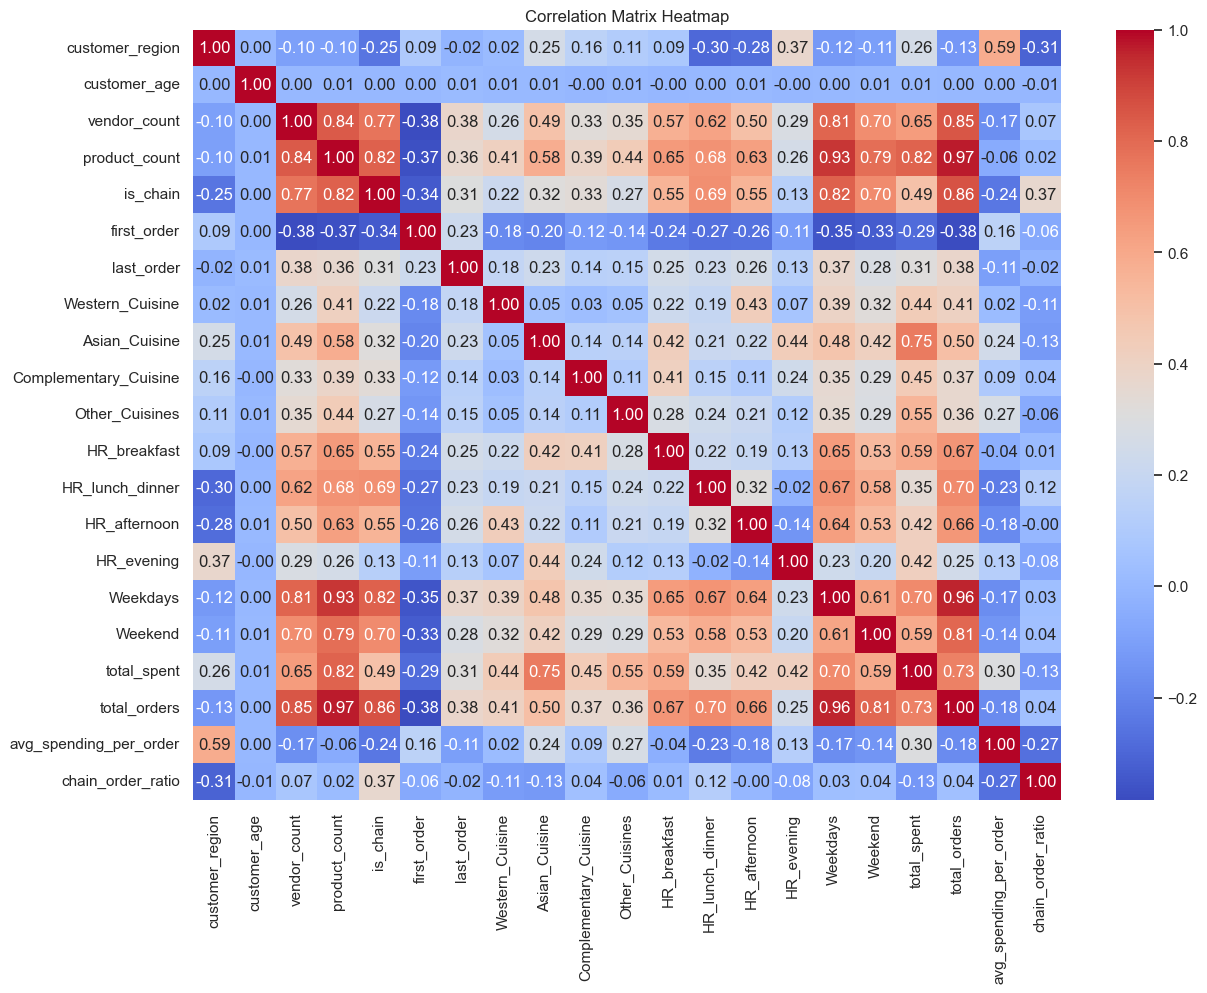

In [144]:
# Define the columns to exclude from the correlation calculation
exclude_columns = ['last_promo', 'payment_method', 'age_category', 'chain_frequency', 'preferred_cui_type', 'preferred_cui',
                   "HR_0", "HR_1", "HR_2", "HR_3", "HR_4", "HR_5", "HR_6", "HR_7", "HR_8", "HR_9", "HR_10",
                   "HR_11", "HR_12", "HR_13", "HR_14", "HR_15", "HR_16", "HR_17", "HR_18", "HR_19", "HR_20",
                   "HR_21", "HR_22", "HR_23", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday",
                   "CUI_American", "CUI_Asian", "CUI_Cafe", "CUI_Beverages", "CUI_Chicken Dishes", "CUI_Chinese", "CUI_Desserts",
                    "CUI_Healthy","CUI_Indian","CUI_Italian","CUI_Japanese","CUI_Noodle Dishes","CUI_OTHER","CUI_Street Food / Snacks","CUI_Thai"]


# Drop the columns to exclude
df_filtered = df.drop(columns=exclude_columns)

# Compute the correlation matrix
correlation_matrix = df_filtered.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

Assess the correlations 


<a class="anchor" id="3rd-bullet">

### Value / RFM perspective
</a>

In [145]:
value_perspetive = ['total_spent', 'avg_spending_per_order', 'last_order']
df_value = df[value_perspetive].copy()

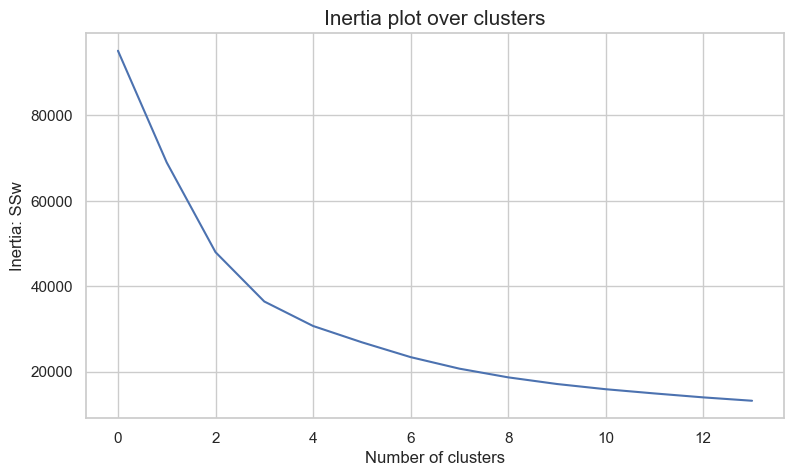

In [146]:
#check optimal number of clusters to keep with an elbow plot

range_clusters = range(1, 15)

inertia = []
for n_clus in range_clusters:  # iterate over each cluster
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=15)
    kmclust.fit(df_value)
    inertia.append(kmclust.inertia_)  # add the inertia of the given cluster solution
    
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [147]:
# Better initialization method and provide more n_init
kmclust = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=15)
kmclust.fit(df_value) #performs clustering ie finds centroids

KMeans(n_clusters=4, n_init=15, random_state=15)

In [148]:
#location of each point
dist_matrix = pd.DataFrame(kmclust.transform(df_value)) #calculates distance of each sample to respective centroid

In [149]:
km_labels = kmclust.predict(df_value) #associates/predicts cluster index for each sample, based on min distance

In [150]:
# Characterizing the final clusters
df_concat = pd.concat([df_value, pd.Series(km_labels, name='value_labels')], axis=1)

# Calculate the mean values for each cluster
df_centroids = df_concat.groupby('value_labels').mean()

# Apply gradient styling to the DataFrame
df_styled = df_centroids.style.background_gradient(cmap='Blues', axis=0)
df_styled

,total_spent,avg_spending_per_order,last_order
value_labels,,,
0,-0.180879,-0.343337,0.535371
1,0.212395,2.043318,-0.275680
2,-0.490841,-0.227734,-1.375132
3,2.684946,0.405896,0.806926


In [151]:
pd.DataFrame(km_labels)[0].value_counts()

0
0    18142
2     7763
1     3443
3     2369
Name: count, dtype: int64

In [152]:
df['value_labels'] = df_concat['value_labels'] # adds labels to scale df

In [153]:
df['value_labels'].value_counts()

value_labels
0    18142
2     7763
1     3443
3     2369
Name: count, dtype: int64

In [154]:
# using R^2
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss # return sum of sum of squares of each df variable

sst = get_ss(df_value) # get total sum of squares
ssw_labels = df_concat.groupby(['value_labels']).apply(get_ss) # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
print('R^2 Score: ', round(r2,3))

R^2 Score:  0.617


In [155]:
silhoutte_score = silhouette_score(df_value, km_labels, random_state=15)

print('Silhouette Score: ', round(silhoutte_score,3))

Silhouette Score:  0.412


In [156]:
calinski_harabasz = calinski_harabasz_score(df_value, km_labels)
print('Calinski Harabasz Score: ', round(calinski_harabasz,3))

Calinski Harabasz Score:  17013.886


This high result indicates that results are well distributed.

In [157]:
# This is step can be quite time consuming

#two_dim = TSNE(random_state=42, perplexity=12).fit_transform(df_value)


In [158]:
# t-SNE visualization
#pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['value_labels'], colormap='tab10', figsize=(15,10))
#plt.show()

<a class="anchor" id="3rd-bullet">

### Preferences Perspective
</a>

In [159]:
df.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes',
       'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'Sunday', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'HR_0',
       'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9',
       'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17',
       'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'age_category',
       'Western_Cuisine', 'Asian_Cuisine', 'Complementary_Cuisine',
       'Other_Cuisines', 'chain_frequency', 'HR_breakfast', 'HR_lunch_dinner',
       'HR_afternoon', 'HR_evening', 'Weekdays', 'Weekend', 'total_spent',
       'total_orders',

In [160]:
preference_features = [
    'Western_Cuisine',
    'Asian_Cuisine',
    'Complementary_Cuisine',
    'Other_Cuisines'
]

df_prf = df[preference_features].copy()

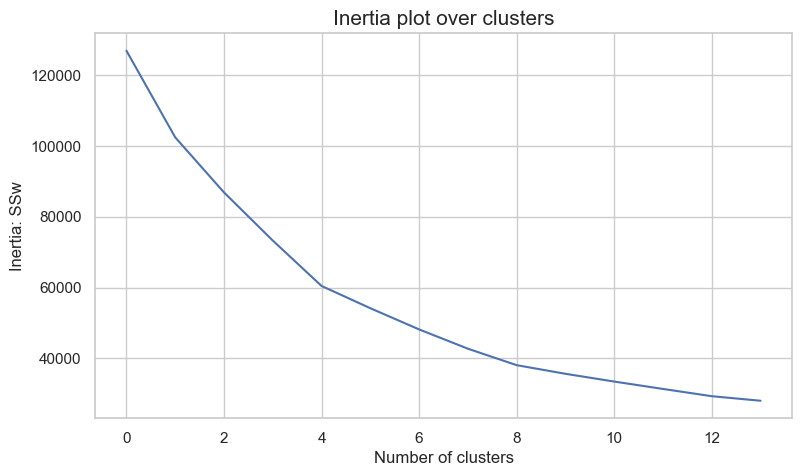

In [161]:
#check  optimal number of clusters to keep with an elbow plot
range_clusters = range(1, 15)

inertia = []
for n_clus in range_clusters:  # iterate over each cluster
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=15)
    kmclust.fit(df_prf)
    inertia.append(kmclust.inertia_)  # add the inertia of the given cluster solution
    
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [162]:
# Better initialization method and provide more n_init
kmclust = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=15)
kmclust.fit(df_prf)

KMeans(n_clusters=4, n_init=15, random_state=15)

In [163]:
dist_matrix = pd.DataFrame(kmclust.transform(df_prf)) #calculates distance of each sample to respective centroid

In [164]:
km_labels = kmclust.predict(df_prf) #associates cluster index for each sample, based on min distance

In [165]:
# Characterizing the final clusters
df_concat = pd.concat([df_prf, pd.Series(km_labels, name='prf_labels')], axis=1)

# Calculate the mean values for each cluster
df_centroids = df_concat.groupby('prf_labels').mean()

# Apply gradient styling to the DataFrame
df_styled = df_centroids.style.background_gradient(cmap='Blues', axis=0)
df_styled

,Western_Cuisine,Asian_Cuisine,Complementary_Cuisine,Other_Cuisines
prf_labels,,,,
0,0.023163,1.940639,0.154800,2.014428
1,2.736470,-0.069411,-0.150640,-0.065872
2,-0.220285,-0.173597,-0.154529,-0.172191
3,0.057290,0.385430,4.109293,0.172360


In [166]:
pd.DataFrame(km_labels)[0].value_counts() #not very well distributed between the 4 centroids

0
2    26405
0     2241
1     2086
3      985
Name: count, dtype: int64

In [167]:
df['prf_labels'] = df_concat['prf_labels'] # adds labels to scale df
df['prf_labels'].value_counts()

prf_labels
2    26405
0     2241
1     2086
3      985
Name: count, dtype: int64

In [168]:
# using R^2
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss # return sum of sum of squares of each df variable

sst = get_ss(df_prf) # get total sum of squares
ssw_labels = df_concat.groupby(['prf_labels']).apply(get_ss) # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels) # remember: SST = SSW + SSB
r2 = ssb / sst
print('R^2 Score: ', round(r2,3))

R^2 Score:  0.422


In [169]:
# This is step can be quite time consuming
#two_dim = TSNE(random_state=42, perplexity=12).fit_transform(df_prf)

# t-SNE visualization
#pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['prf_labels'], colormap='tab10', figsize=(15,10))
#plt.show()

<a class="anchor" id="3rd-bullet">

### Behaviour/demographic Based Perspective
</a>

In [170]:
df.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes',
       'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'Sunday', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'HR_0',
       'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9',
       'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17',
       'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'age_category',
       'Western_Cuisine', 'Asian_Cuisine', 'Complementary_Cuisine',
       'Other_Cuisines', 'chain_frequency', 'HR_breakfast', 'HR_lunch_dinner',
       'HR_afternoon', 'HR_evening', 'Weekdays', 'Weekend', 'total_spent',
       'total_orders',

In [171]:
behaviour_features = [
    'Weekdays',
    'chain_order_ratio',
    'HR_breakfast',
    'HR_lunch_dinner',
    'HR_afternoon',
    'HR_evening'
]

df_beh = df[behaviour_features].copy()

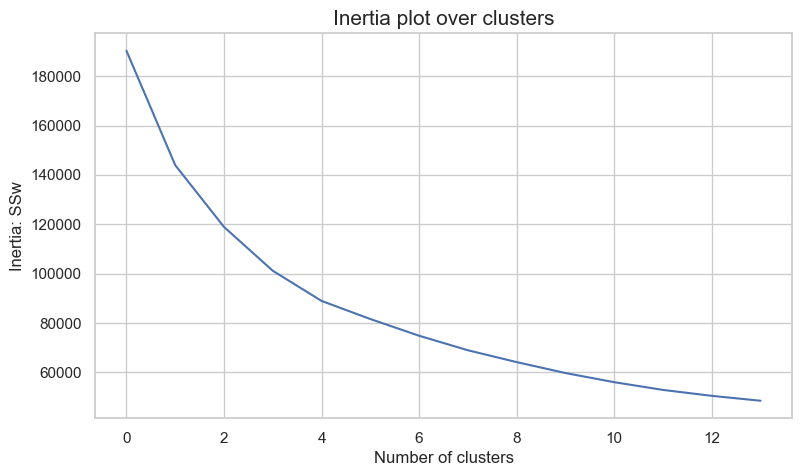

In [172]:
# check the optimal number of clusters to keep with an elbow plot
range_clusters = range(1, 15)

inertia = []
for n_clus in range_clusters:  # iterate over each ncluster
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=15)
    kmclust.fit(df_beh)
    inertia.append(kmclust.inertia_)  # add the inertia of the given cluster solution
    
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

In [173]:
# Better initialization method and provide more n_init
kmclust = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=15)
kmclust.fit(df_beh) #performs clustering ie finds centroids

KMeans(n_clusters=4, n_init=15, random_state=15)

In [174]:
dist_matrix = pd.DataFrame(kmclust.transform(df_beh)) #calculates distance of each sample to respective centroid

In [175]:
km_labels = kmclust.predict(df_beh) #associates cluster index for each sample, based on min distance

In [176]:
# Characterizing the final clusters
df_concat = pd.concat([df_beh, pd.Series(km_labels, name='beh_labels')], axis=1)

# Calculate the mean values for each cluster
df_centroids = df_concat.groupby('beh_labels').mean()

# Apply gradient styling to the DataFrame
df_styled = df_centroids.style.background_gradient(cmap='Blues', axis=0)
df_styled


,Weekdays,chain_order_ratio,HR_breakfast,HR_lunch_dinner,HR_afternoon,HR_evening
beh_labels,,,,,,
0,-0.302554,-1.109420,-0.191904,-0.274615,-0.136620,-0.138942
1,2.629220,0.169367,1.654613,2.076183,2.142190,-0.146792
2,-0.225583,0.780643,-0.143227,-0.069743,-0.144234,-0.225633
3,0.722072,-0.219046,0.475060,-0.171894,-0.451298,3.056027


In [177]:
pd.DataFrame(km_labels)[0].value_counts()

0
2    16263
0    11420
1     2208
3     1826
Name: count, dtype: int64

In [178]:
df['beh_labels'] = df_concat['beh_labels'] # adds labels to scale df
df['beh_labels'].value_counts()

beh_labels
2    16263
0    11420
1     2208
3     1826
Name: count, dtype: int64

**better distributed than preference features**

In [179]:
# using R^2
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss # return sum of sum of squares of each df variable

sst = get_ss(df_beh) # get total sum of squares
ssw_labels = df_concat.groupby(['beh_labels']).apply(get_ss) # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels) # remember: SST = SSW + SSB
r2 = ssb / sst
print('R^2 Score: ', round(r2,3))

R^2 Score:  0.468


In [180]:
silhoutte_score = silhouette_score(df_beh, km_labels, random_state=15)

print('Silhouette Score: ', round(silhoutte_score,3))

Silhouette Score:  0.317


In [181]:
calinski_harabasz = calinski_harabasz_score(df_beh, km_labels)
print('Calinski Harabasz Score: ', round(calinski_harabasz,3))

Calinski Harabasz Score:  9313.687


In [182]:
# This is step can be quite time consuming
#two_dim = TSNE(random_state=42, perplexity=12).fit_transform(df_beh)

# t-SNE visualization
#pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['beh_labels'], colormap='tab10', figsize=(15,10))
#plt.show()

<a class="anchor" id="3rd-bullet">

### Merging cluster Kmeans:
</a>

In [183]:
# Count label frequencies (contigency table)

pd.crosstab(df['value_labels'],
            df['prf_labels'])

prf_labels,0,1,2,3
value_labels,,,,
0,360,1240,16180,362
1,482,203,2573,185
2,18,115,7603,27
3,1381,528,49,411


In [184]:
to_merge = [(0,0), (0,3)]

In [185]:
# Get centroids of clusters
df_centroids = df.groupby(['value_labels', 'prf_labels'])\
    [preference_features + value_perspetive].mean()

df_centroids

Western_Cuisine  Asian_Cuisine  \
value_labels prf_labels                                   
0            0                 -0.220666       0.669743   
             1                  2.100390      -0.331461   
             2                 -0.182430      -0.152883   
             3                 -0.257649      -0.223279   
1            0                 -0.372229       0.538742   
             1                  2.086307      -0.227574   
             2                 -0.321781       0.223123   
             3                 -0.366565      -0.374313   
2            0                 -0.318527       0.459803   
             1                  1.770374      -0.512555   
             2                 -0.270722      -0.364201   
             3                 -0.397677      -0.470397   
3            0                  0.229179       2.780532   
             1                  4.690679       0.703338   
             2                  0.435544       1.729504   
             3                  0.555355       1.319765   

                         Complementary_Cuisine  Other_Cuisines  total_spent  \
value_labels prf_labels                                                       
0            0                       -0.097717        1.607062     0.962950   
             1                       -0.256928       -0.211848     0.423394   
             2                       -0.130769       -0.158460    -0.269861   
             3                        3.006382       -0.203780     0.588872   
1            0                       -0.149352        2.506908     1.172454   
             1                       -0.234669       -0.295419     0.456545   
             2                       -0.154351        0.033995    -0.013926   
             3                        3.513866       -0.240472     0.590846   
2            0                       -0.083019        1.925608     0.926896   
             1                       -0.221480       -0.342038     0.141528   
             2                       -0.209207       -0.270726    -0.506347   
             3                        2.785438       -0.390373     0.236767   
3            0                        0.329882        1.949892     2.737189   
             1                        0.146711        0.425353     2.441574   
             2                        0.474885       -0.244001     1.303668   
             3                        5.435697        0.726449     2.986732   

                         avg_spending_per_order  last_order  
value_labels prf_labels                                      
0            0                        -0.214033    0.712279  
             1                        -0.121829    0.620022  
             2                        -0.368090    0.522175  
             3                        -0.124287    0.659308  
1            0                         2.889377   -0.002035  
             1                         1.980231   -0.216563  
             2                         1.864362   -0.340132  
             3                         2.397155   -0.157093  
2            0                         0.218317   -1.364621  
             1                         0.193613   -1.233245  
             2                        -0.236560   -1.377987  
             3                         0.165449   -1.182479  
3            0                         0.559689    0.790063  
             1                         0.097657    0.826260  
             2                         0.391796    0.829791  
             3                         0.286802    0.836025

In [186]:
# Computing the euclidean distance matrix between the centroids
centroid_dists = euclidean = pairwise_distances(df_centroids)

df_dists = pd.DataFrame(
    centroid_dists, 
    columns=df_centroids.index, 
    index=df_centroids.index
)

df_dists

value_labels                    0                                       1  \
prf_labels                      0         1         2         3         0   
value_labels prf_labels                                                     
0            0           0.000000  3.167274  2.318627  3.723470  3.322320   
             1           3.167274  0.000000  2.410964  4.031159  4.928460   
             2           2.318627  2.410964  0.000000  3.266505  4.537076   
             3           3.723470  4.031159  3.266505  0.000000  5.268815   
1            0           3.322320  4.928460  4.537076  5.268815  0.000000   
             1           3.962257  2.266738  3.430789  4.606584  3.984602   
             2           3.011482  3.362074  2.447716  3.945520  2.964784   
             3           5.028004  5.223470  4.714004  2.705133  4.733451   
2            0           2.158027  3.922275  3.174213  4.344758  3.066419   
             1           3.715151  1.942540  2.747906  4.303220  4.864514   
             2           3.337456  3.240156  1.937795  3.965754  4.798701   
             3           4.230252  4.349008  3.486026  1.940209  5.264502   
3            0           2.951404  4.904124  4.838036  5.114883  3.798751   
             1           5.279686  3.537388  5.706085  6.117821  6.338068   
             2           2.409343  2.939144  2.729003  3.392685  4.120030   
             3           6.064711  6.721934  6.753845  3.969737  6.826461   

value_labels                                                  2            \
prf_labels                      1         2         3         0         1   
value_labels prf_labels                                                     
0            0           3.962257  3.011482  5.028004  2.158027  3.715151   
             1           2.266738  3.362074  5.223470  3.922275  1.942540   
             2           3.430789  2.447716  4.714004  3.174213  2.747906   
             3           4.606584  3.945520  2.705133  4.344758  4.303220   
1            0           3.984602  2.964784  4.733451  3.066419  4.864514   
             1           0.000000  2.523295  4.504225  3.981869  2.123266   
             2           2.523295  0.000000  3.817486  2.878108  2.945753   
             3           4.504225  3.817486  0.000000  4.964467  4.976377   
2            0           3.981869  2.878108  4.964467  0.000000  3.332424   
             1           2.123266  2.945753  4.976377  3.332424  0.000000   
             2           3.572918  2.485340  4.847922  2.789686  2.195235   
             3           4.431019  3.601094  2.592407  3.869832  3.709252   
3            0           5.107870  4.614888  5.841540  3.727359  5.453613   
             1           4.109285  6.009190  6.942476  5.879095  4.502446   
             2           3.375927  2.930729  4.450659  3.490948  3.598485   
             3           6.950743  6.824669  4.419090  6.518272  7.096811   

value_labels                                        3                          \
prf_labels                      2         3         0         1             2   
value_labels prf_labels                                                         
0            0           3.337456  4.230252  2.951404  5.279686  2.409343e+00   
             1           3.240156  4.349008  4.904124  3.537388  2.939144e+00   
             2           1.937795  3.486026  4.838036  5.706085  2.729003e+00   
             3           3.965754  1.940209  5.114883  6.117821  3.392685e+00   
1            0           4.798701  5.264502  3.798751  6.338068  4.120030e+00   
             1           3.572918  4.431019  5.107870  4.109285  3.375927e+00   
             2           2.485340  3.601094  4.614888  6.009190  2.930729e+00   
             3           4.847922  2.592407  5.841540  6.942476  4.450659e+00   
2            0           2.789686  3.869832  3.727359  5.879095  3.490948e+00   
             1           2.195235  3.709252  5.453613  4.502446  3.598485e+00   
             2     

In [187]:
# Merging each low frequency clustering (source) 
# to the closest cluster (target)

source_target = {}

for clus in to_merge:
    # If cluster to merge (source) has not yet been used as target
    if clus not in source_target.values():
        # Add this cluster to source_target map as key
        # Use the cluster with the smallest distance to it as value
        source_target[clus] = df_dists.loc[clus].sort_values().index[1]

source_target

{(0, 0): (2, 0), (0, 3): (2, 3)}

In [188]:
df_ = df.copy()

# Changing the value_labels and prf_labels based on source_target
for source, target in source_target.items():
    mask = (df_['value_labels']==source[0]) & (df_['prf_labels']==source[1])
    df_.loc[mask, 'value_labels'] = target[0]
    df_.loc[mask, 'prf_labels'] = target[1]

In [189]:
# New contigency table

pd.crosstab(df_['value_labels'],
            df_['prf_labels'])

prf_labels,0,1,2,3
value_labels,,,,
0,0,1240,16180,0
1,482,203,2573,185
2,378,115,7603,389
3,1381,528,49,411


In [190]:
# Original contigency table

pd.crosstab(df['value_labels'],
            df['prf_labels'])


prf_labels,0,1,2,3
value_labels,,,,
0,360,1240,16180,362
1,482,203,2573,185
2,18,115,7603,27
3,1381,528,49,411


<a class="anchor" id="3rd-bullet">

### Merging using Hierarchical clustering - USED ONE
</a>

In [191]:
df.head()

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,...,Weekend,total_spent,total_orders,avg_spending_per_order,chain_order_ratio,preferred_cui,preferred_cui_type,value_labels,prf_labels,beh_labels
0,2360,-1.337468,-0.405436,-0.098281,-0.475544,-1.175717,-2.706721,DELIVERY,DIGI,-0.422050,...,0.429816,-0.209739,-0.4837,0.528655,-0.327866,CUI_Indian,Asian_Cuisine,2,2,0
1,8670,-1.478630,-0.405436,-0.555346,-0.212185,-1.175717,-2.706721,DISCOUNT,DIGI,0.686724,...,0.429816,-0.427887,-0.4837,-0.088755,0.963778,CUI_American,Western_Cuisine,2,2,2
2,4660,1.485773,-0.771607,-0.555346,-0.212185,-1.175717,-2.706721,DISCOUNT,CASH,0.373638,...,0.429816,-0.653705,-0.4837,-0.727873,0.963778,CUI_American,Western_Cuisine,2,2,2
3,4660,-0.208171,-0.405436,-0.402991,-0.475544,-1.175717,-2.663582,DELIVERY,DIGI,-0.422050,...,-0.148714,-0.149281,-0.4837,0.699767,-0.327866,CUI_Indian,Asian_Cuisine,2,2,0
4,4660,-1.055144,-0.405436,-0.098281,-0.738902,-1.175717,-2.663582,-,DIGI,0.838078,...,-0.148714,0.389434,-0.4837,2.224456,-1.619510,CUI_Asian,Asian_Cuisine,1,2,0


In [192]:
metric_features = value_perspetive + behaviour_features + preference_features

In [193]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['value_labels', 'prf_labels', 'beh_labels'])\
    [metric_features].mean()
df_centroids

total_spent  avg_spending_per_order  \
value_labels prf_labels beh_labels                                        
0            0          0              0.873194                0.217919   
                        1              1.036084               -0.628221   
                        2              0.872600                0.107340   
                        3              0.984230                0.129892   
             1          0              0.323133               -0.038136   
                        1              0.895391               -0.540821   
                        2              0.334036               -0.069688   
                        3              0.510775               -0.019103   
             2          0             -0.271116               -0.147690   
                        1              0.390452               -0.785093   
                        2             -0.356865               -0.480887   
                        3              0.225331               -0.171667   
             3          0              0.475945                0.157699   
                        1              0.877895               -0.629475   
                        2              0.432096               -0.032447   
                        3              0.703157                0.000757   
1            0          0              1.191975                3.051620   
                        2              1.069533                2.887199   
                        3              1.406727                1.700842   
             1          0              0.345727                2.049959   
                        2              0.394852                2.049247   
                        3              1.104093                1.485817   
             2          0             -0.008564                1.869948   
                        2             -0.059165                1.886280   
                        3              0.748752                1.241339   
             3          0              0.584114                2.463972   
                        2              0.497860                2.514038   
                        3              1.134301                1.460013   
2            0          0              0.826507                0.480100   
                        1              2.024867               -0.552900   
                        2              0.732636                0.142407   
                        3              0.800013               -0.139833   
             1          0              0.080516                0.153384   
                        1              1.269470               -0.453647   
                        2              0.116965                0.288914   
                        3              0.363829                0.143714   
             2          0             -0.454608               -0.011120   
                        1              0.131920               -0.834174   
                        2             -0.547409               -0.370604   
                        3             -0.036687               -0.131741   
             3          0              0.142862                0.475188   
                        1              1.248603               -0.448977   
                        2              0.096325                0.147052   
                        3              0.305439                0.155070   
3            0          0              2.149323                1.195096   
                        1              2.971934               -0.184565   
                        2              2.078194                1.086229   
                        3              3.021918                0.794089   
             1          0              1.648973                0.570927   
                        1              2.714175               -0.159409   
                        2              1.598494                0.602064   
                        3              2.255377              

In [194]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids)

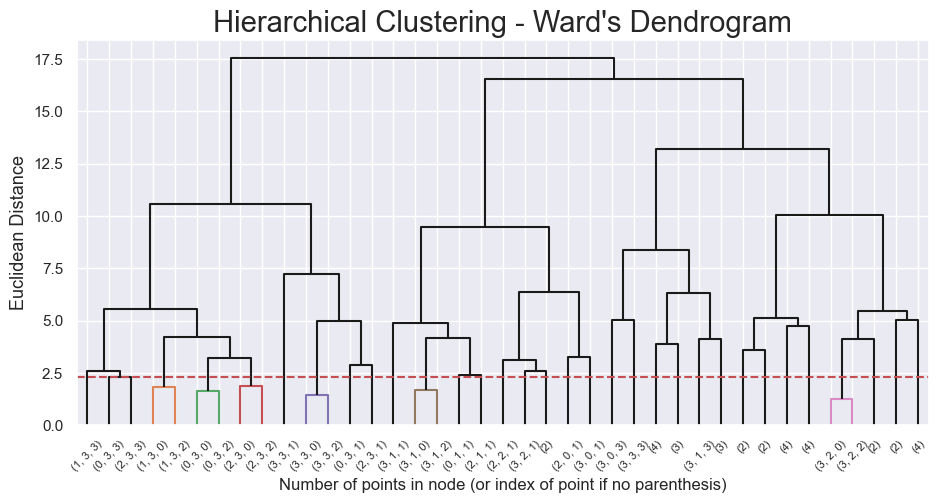

In [195]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned

y_threshold = 2.3
# y_threshold = 3.3

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [196]:
#hierarchical_clustering_methods_nclust_analysis(df[metric_features], ["ward"], 7) 8 minutes to run

In [197]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=6
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

total_spent  avg_spending_per_order  \
value_labels prf_labels beh_labels                                        
0            0          0              0.873194                0.217919   
                        1              1.036084               -0.628221   
                        2              0.872600                0.107340   
                        3              0.984230                0.129892   
             1          0              0.323133               -0.038136   
                        1              0.895391               -0.540821   
                        2              0.334036               -0.069688   
                        3              0.510775               -0.019103   
             2          0             -0.271116               -0.147690   
                        1              0.390452               -0.785093   
                        2             -0.356865               -0.480887   
                        3              0.225331               -0.171667   
             3          0              0.475945                0.157699   
                        1              0.877895               -0.629475   
                        2              0.432096               -0.032447   
                        3              0.703157                0.000757   
1            0          0              1.191975                3.051620   
                        2              1.069533                2.887199   
                        3              1.406727                1.700842   
             1          0              0.345727                2.049959   
                        2              0.394852                2.049247   
                        3              1.104093                1.485817   
             2          0             -0.008564                1.869948   
                        2             -0.059165                1.886280   
                        3              0.748752                1.241339   
             3          0              0.584114                2.463972   
                        2              0.497860                2.514038   
                        3              1.134301                1.460013   
2            0          0              0.826507                0.480100   
                        1              2.024867               -0.552900   
                        2              0.732636                0.142407   
                        3              0.800013               -0.139833   
             1          0              0.080516                0.153384   
                        1              1.269470               -0.453647   
                        2              0.116965                0.288914   
                        3              0.363829                0.143714   
             2          0             -0.454608               -0.011120   
                        1              0.131920               -0.834174   
                        2             -0.547409               -0.370604   
                        3             -0.036687               -0.131741   
             3          0              0.142862                0.475188   
                        1              1.248603               -0.448977   
                        2              0.096325                0.147052   
                        3              0.305439                0.155070   
3            0          0              2.149323                1.195096   
                        1              2.971934               -0.184565   
                        2              2.078194                1.086229   
                        3              3.021918                0.794089   
             1          0              1.648973                0.570927   
                        1              2.714175               -0.159409   
                        2              1.598494                0.602064   
                        3              2.255377              

In [198]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper

{(0, 0, 0): 2,
 (0, 0, 1): 0,
 (0, 0, 2): 2,
 (0, 0, 3): 1,
 (0, 1, 0): 5,
 (0, 1, 1): 0,
 (0, 1, 2): 5,
 (0, 1, 3): 1,
 (0, 2, 0): 5,
 (0, 2, 1): 0,
 (0, 2, 2): 5,
 (0, 2, 3): 1,
 (0, 3, 0): 4,
 (0, 3, 1): 3,
 (0, 3, 2): 4,
 (0, 3, 3): 4,
 (1, 0, 0): 2,
 (1, 0, 2): 2,
 (1, 0, 3): 1,
 (1, 1, 0): 5,
 (1, 1, 2): 5,
 (1, 1, 3): 1,
 (1, 2, 0): 5,
 (1, 2, 2): 5,
 (1, 2, 3): 1,
 (1, 3, 0): 4,
 (1, 3, 2): 4,
 (1, 3, 3): 4,
 (2, 0, 0): 2,
 (2, 0, 1): 0,
 (2, 0, 2): 2,
 (2, 0, 3): 1,
 (2, 1, 0): 5,
 (2, 1, 1): 0,
 (2, 1, 2): 5,
 (2, 1, 3): 1,
 (2, 2, 0): 5,
 (2, 2, 1): 0,
 (2, 2, 2): 5,
 (2, 2, 3): 1,
 (2, 3, 0): 4,
 (2, 3, 1): 3,
 (2, 3, 2): 4,
 (2, 3, 3): 4,
 (3, 0, 0): 2,
 (3, 0, 1): 0,
 (3, 0, 2): 2,
 (3, 0, 3): 1,
 (3, 1, 0): 0,
 (3, 1, 1): 0,
 (3, 1, 2): 0,
 (3, 1, 3): 1,
 (3, 2, 0): 2,
 (3, 2, 1): 0,
 (3, 2, 2): 2,
 (3, 2, 3): 1,
 (3, 3, 0): 3,
 (3, 3, 1): 3,
 (3, 3, 2): 3,
 (3, 3, 3): 1}

In [199]:
df_hc = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_hc['merged_labels'] = df_hc.apply(
    lambda row: cluster_mapper[
        (row['value_labels'], row['prf_labels'], row['beh_labels'])
    ], axis=1
)

df_hc

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,...,total_spent,total_orders,avg_spending_per_order,chain_order_ratio,preferred_cui,preferred_cui_type,value_labels,prf_labels,beh_labels,merged_labels
0,2360,-1.337468,-0.405436,-0.098281,-0.475544,-1.175717,-2.706721,DELIVERY,DIGI,-0.422050,...,-0.209739,-0.48370,0.528655,-0.327866,CUI_Indian,Asian_Cuisine,2,2,0,5
1,8670,-1.478630,-0.405436,-0.555346,-0.212185,-1.175717,-2.706721,DISCOUNT,DIGI,0.686724,...,-0.427887,-0.48370,-0.088755,0.963778,CUI_American,Western_Cuisine,2,2,2,5
2,4660,1.485773,-0.771607,-0.555346,-0.212185,-1.175717,-2.706721,DISCOUNT,CASH,0.373638,...,-0.653705,-0.48370,-0.727873,0.963778,CUI_American,Western_Cuisine,2,2,2,5
3,4660,-0.208171,-0.405436,-0.402991,-0.475544,-1.175717,-2.663582,DELIVERY,DIGI,-0.422050,...,-0.149281,-0.48370,0.699767,-0.327866,CUI_Indian,Asian_Cuisine,2,2,0,5
4,4660,-1.055144,-0.405436,-0.098281,-0.738902,-1.175717,-2.663582,-,DIGI,0.838078,...,0.389434,-0.48370,2.224456,-1.619510,CUI_Asian,Asian_Cuisine,1,2,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31712,8670,0.356477,-0.771607,-0.707701,-0.475544,-1.175717,-2.749860,FREEBIE,DIGI,-0.422050,...,-0.454282,-0.68905,0.988360,0.963778,CUI_Beverages,Complementary_Cuisine,2,2,2,5
31713,8670,-0.208171,-0.771607,-0.707701,-0.738902,-1.175717,-2.749860,DELIVERY,DIGI,1.138191,...,-0.454282,-0.68905,0.988360,-1.619510,CUI_American,Western_Cuisine,2,2,0,5
31714,8670,-0.490496,-0.771607,-0.707701,-0.475544,-1.175717,-2.749860,-,DIGI,-0.422050,...,-0.459921,-0.68905,0.956436,0.963778,CUI_Desserts,Complementary_Cuisine,2,2,2,5
31715,8670,0.921125,-0.771607,-0.707701,-0.738902,-1.175717,-2.749860,DISCOUNT,DIGI,-0.422050,...,-0.589863,-0.68905,0.220908,-1.619510,CUI_Asian,Asian_Cuisine,2,2,0,5


In [200]:
df_hc['merged_labels'].value_counts()

merged_labels
5    26082
0     2045
1     1729
2     1034
4      495
3      332
Name: count, dtype: int64

In [201]:
# To revert back to original values
original_values = ss_scaler.inverse_transform(df_hc[columns_to_scale])

# Update the df with the original values
df_hc[columns_to_scale] = original_values

# Calculate the mean of each group
df_centroids = df_hc[metric_features + ['merged_labels']].groupby('merged_labels').mean(numeric_only=True)

# Apply gradient styling to the DataFrame
df_styled = df_centroids.style.background_gradient(cmap='Blues', axis=0)
df_styled

,total_spent,avg_spending_per_order,last_order,Weekdays,chain_order_ratio,HR_breakfast,HR_lunch_dinner,HR_afternoon,HR_evening,Western_Cuisine,Asian_Cuisine,Complementary_Cuisine,Other_Cuisines
merged_labels,,,,,,,,,,,,,
0,106.891125,6.877015,82.826406,11.926161,0.675064,4.134474,5.792665,6.139364,0.298289,31.210015,45.993873,7.194616,22.492621
1,102.826987,13.005148,76.478890,5.748988,0.536153,2.255061,0.902256,0.341816,4.521689,13.388005,61.047565,13.334627,15.056790
2,104.290203,24.200248,72.025145,3.659574,0.458327,2.190522,1.292070,1.284333,0.564797,4.656025,44.939381,3.970571,50.724226
3,149.609819,9.632590,82.644578,13.009036,0.696245,7.849398,4.903614,5.027108,0.515060,16.541175,39.976898,73.306265,19.785482
4,61.350869,17.455882,69.486869,3.466667,0.678937,2.169697,0.771717,0.585859,1.309091,2.593758,8.369556,47.392000,2.995556
5,24.024732,9.710741,60.726056,2.075186,0.633974,0.773177,0.903573,1.022583,0.246300,6.098277,11.149803,2.544474,4.232178


In [202]:
df_hc.head(1)

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,...,total_spent,total_orders,avg_spending_per_order,chain_order_ratio,preferred_cui,preferred_cui_type,value_labels,prf_labels,beh_labels,merged_labels
0,2360,18.0,2.0,5.0,1.0,0.0,1.0,DELIVERY,DIGI,0.0,...,28.88,2.0,14.44,0.5,CUI_Indian,Asian_Cuisine,2,2,0,5


<div class="alert alert-block alert-success">

<a class="anchor" id="1st-bullet">    </a>
## 3. Cluster Analysis & Profiling with categorical features
    

    
</div>

<a class="anchor" id="3rd-bullet">

### Cluster Analysis:
</a>

In [203]:
def cluster_profiles(df, label_columns, figsize, 
                     cmap="tab10",
                     compare_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    
    if compare_titles == None:
        compare_titles = [""]*len(label_columns)
        
    fig, axes = plt.subplots(nrows=len(label_columns), 
                             ncols=2, 
                             figsize=figsize, 
                             constrained_layout=True,
                             squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compare_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, 
                                            label, 
                                            color = sns.color_palette(cmap),
                                            ax=ax[0])



        sns.barplot(x=label, 
                    hue=label,
                    y="counts", 
                    data=counts, 
                    ax=ax[1], 
                    palette=sns.color_palette(cmap),
                    legend=False
                    )

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), 
                              rotation=40,
                              ha='right'
                              )
        
        ax[0].legend(handles, cluster_labels,
                     loc='center left', bbox_to_anchor=(1, 0.5), title=label
                     ) # Adaptable to number of clusters
        
        ax[1].set_xticks([i for i in range(len(handles))])
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
        
        
    
    # plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profiling", fontsize=23)
    plt.show()

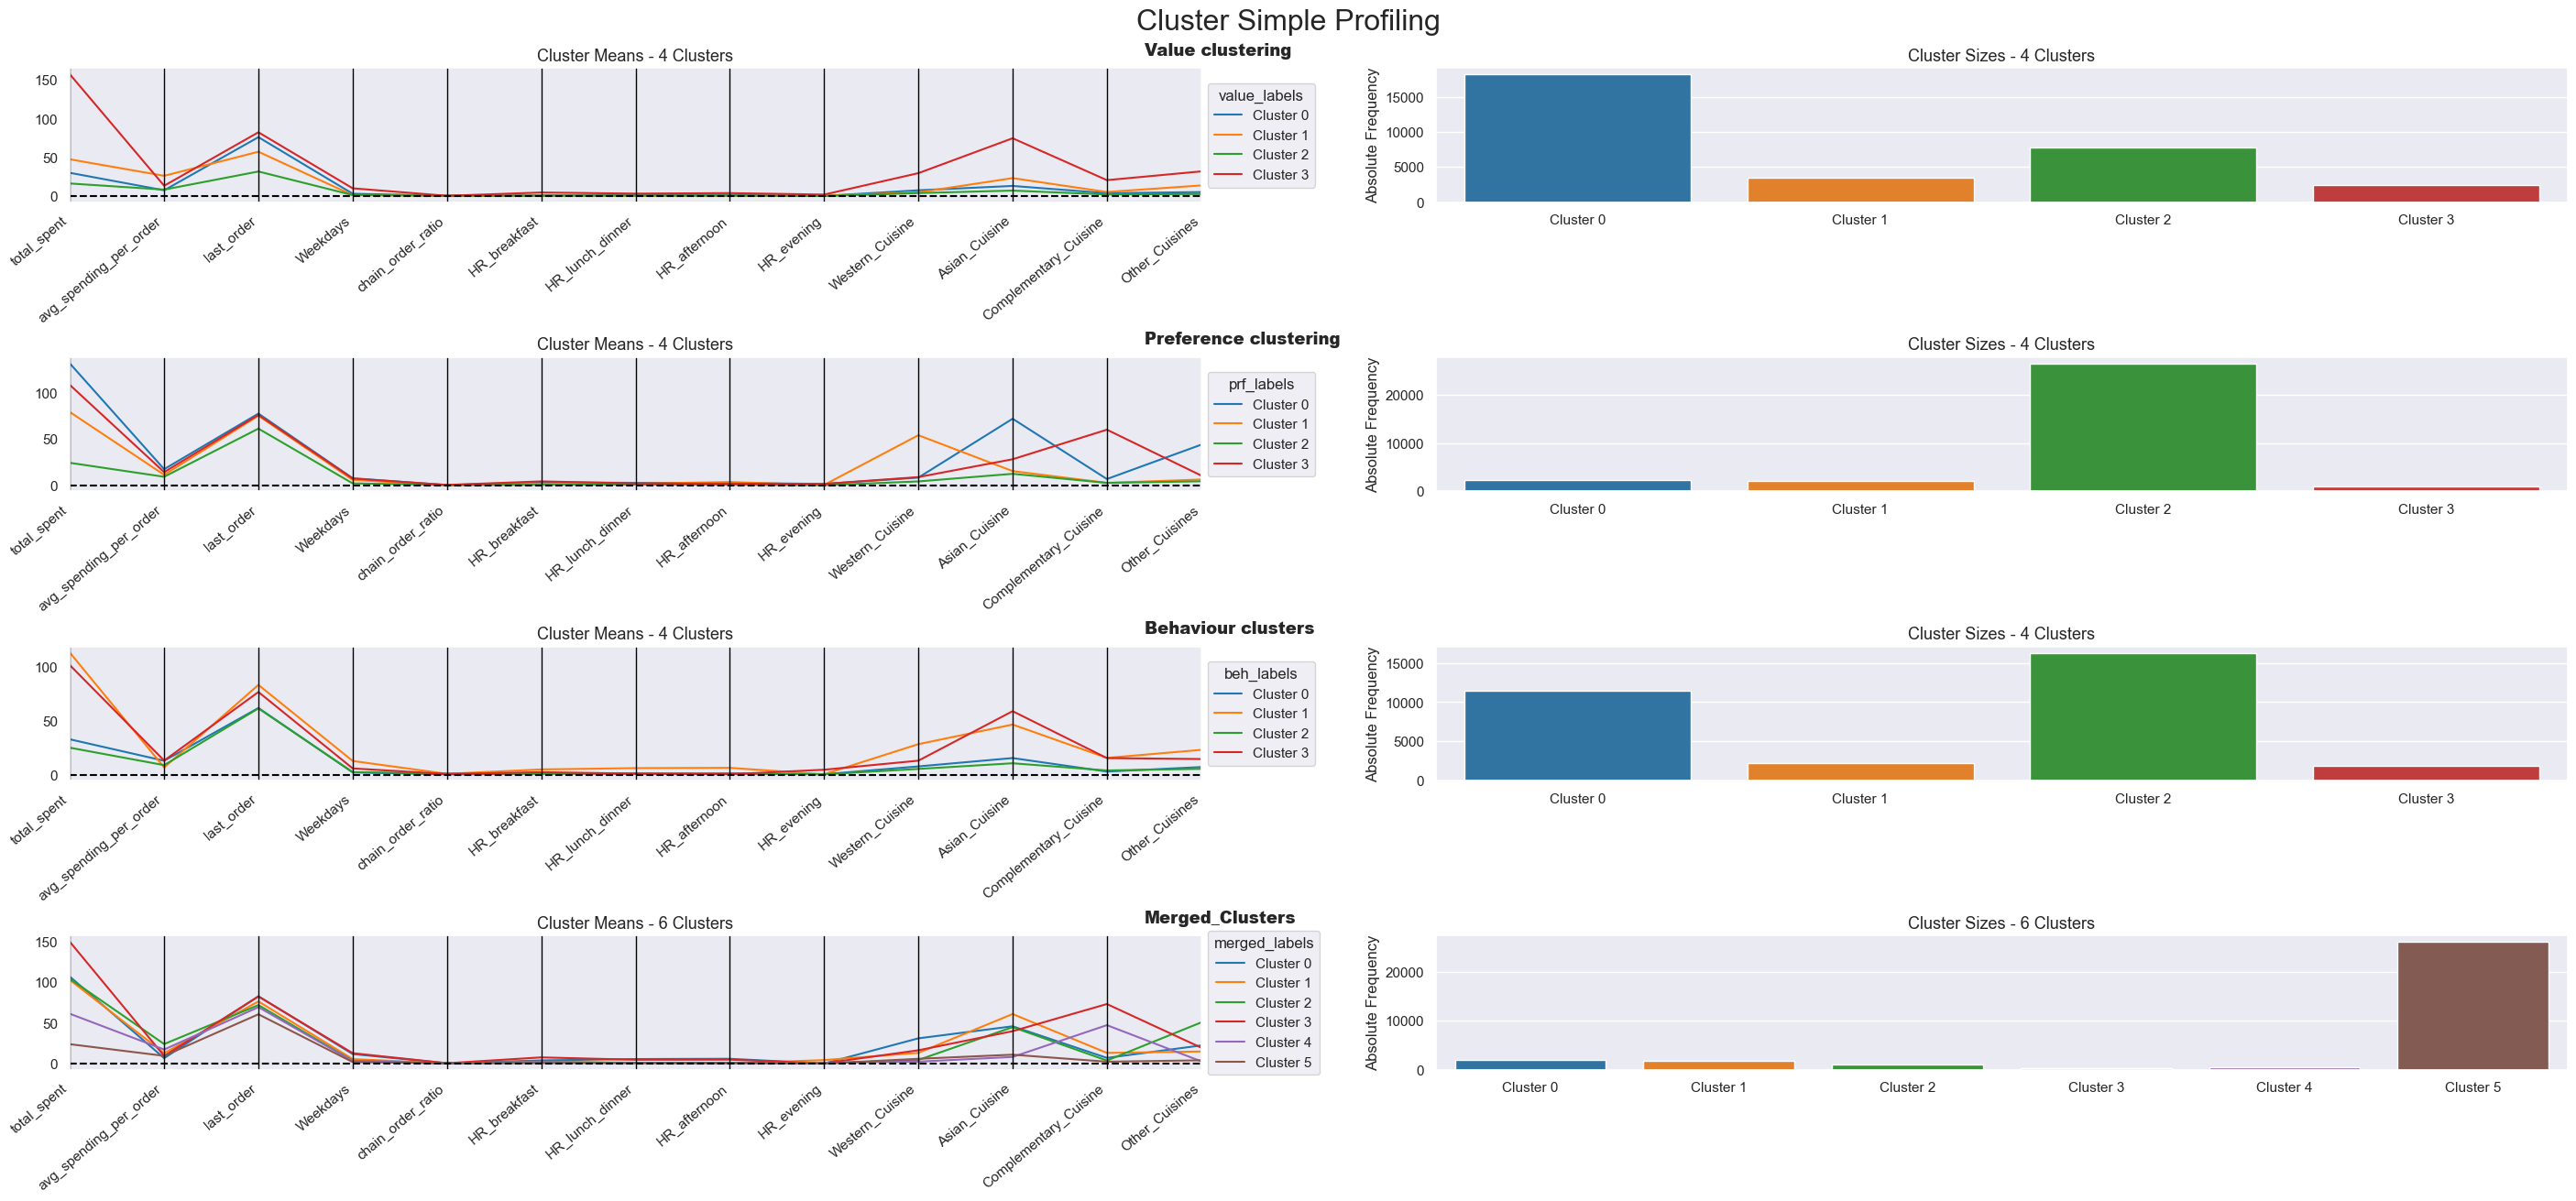

In [204]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df_hc[metric_features + ['value_labels', 'prf_labels', 'beh_labels', 'merged_labels']], 
    label_columns = ['value_labels', 'prf_labels', 'beh_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compare_titles = ["Value clustering", "Preference clustering", "Behaviour clusters", "Merged_Clusters"]
)

<a class="anchor" id="3rd-bullet">

### Profiling - Association categorical labels
</a>

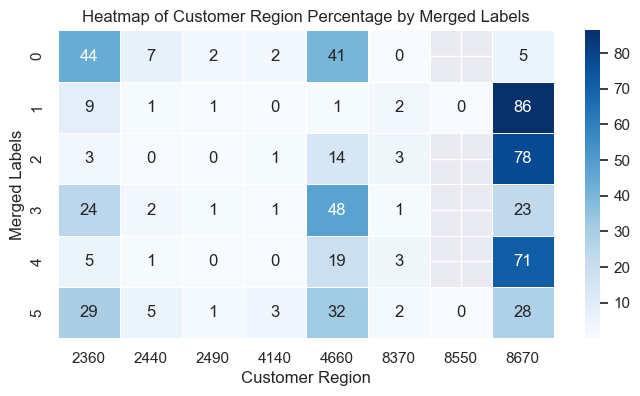

In [205]:
# Group by merged_labels and customer_region
df_cl_region = df_hc.groupby(['merged_labels', 'customer_region'])['customer_region'].size().unstack()

# Calculate the percentage distribution
df_cl_region_pct = df_cl_region.copy()
for i in df_hc['customer_region'].unique():
    df_cl_region_pct[i] = 100 * df_cl_region_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_cl_region_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5)
plt.title('Heatmap of Customer Region Percentage by Merged Labels')
plt.xlabel('Customer Region')
plt.ylabel('Merged Labels')
plt.show()


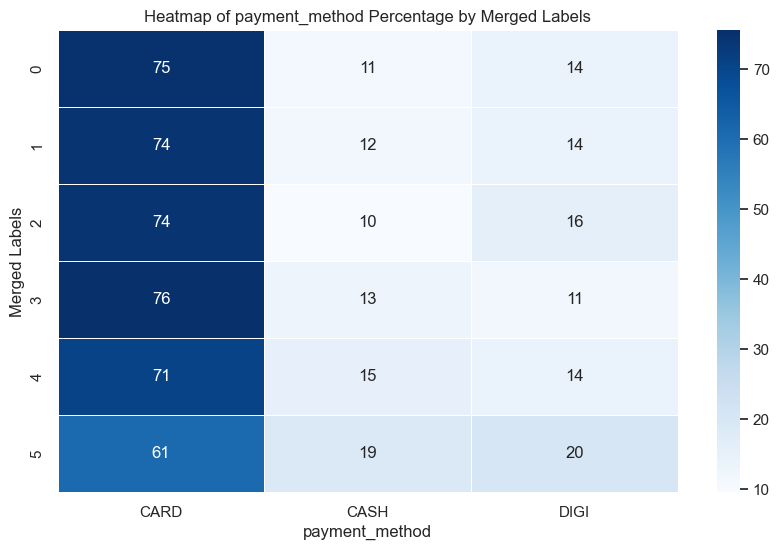

In [206]:
# Group by merged_labels and payment_method
df_cl_payment = df_hc.groupby(['merged_labels', 'payment_method'])['payment_method'].size().unstack()

# Calculate the percentage distribution
df_cl_payment_pct = df_cl_payment.copy()
for i in df_hc['payment_method'].unique():
    df_cl_payment_pct[i] = 100 * df_cl_payment_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_cl_payment_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5)
plt.title('Heatmap of payment_method Percentage by Merged Labels')
plt.xlabel('payment_method')
plt.ylabel('Merged Labels')
plt.show()

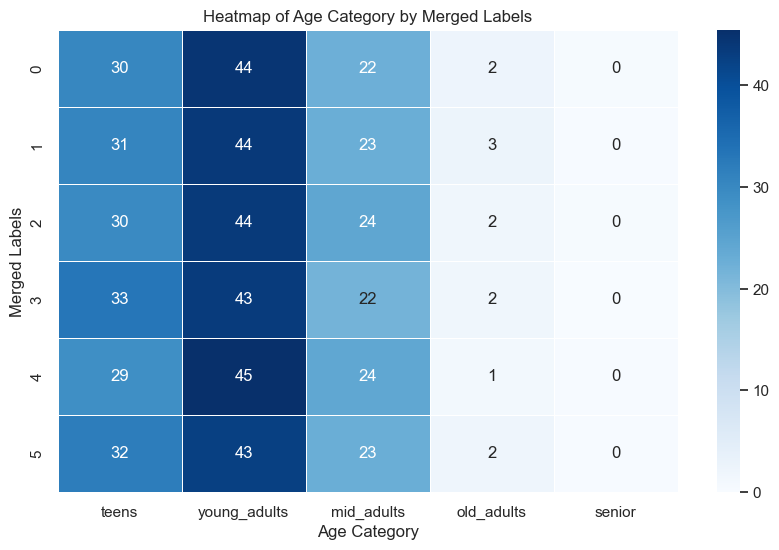

In [207]:
# Group by merged_labels and age_category
# Define the order of age categories from youngest to oldest
age_order = ['teens', 'young_adults', 'mid_adults', 'old_adults', 'senior']
df_hc['age_category'] = pd.Categorical(df_['age_category'], categories=age_order, ordered=True)

df_cl_age = df_hc.groupby(['merged_labels', 'age_category'])['age_category'].size().unstack()

# Reorder the columns based on the defined age order
df_cl_age = df_cl_age[age_order]

# Calculate the percentage distribution
df_cl_age_pct = df_cl_age.copy()
for i in df_hc['age_category'].unique():
    df_cl_age_pct[i] = 100 * df_cl_age_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_cl_age_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5)
plt.title('Heatmap of Age Category by Merged Labels')
plt.xlabel('Age Category')
plt.ylabel('Merged Labels')
plt.show()

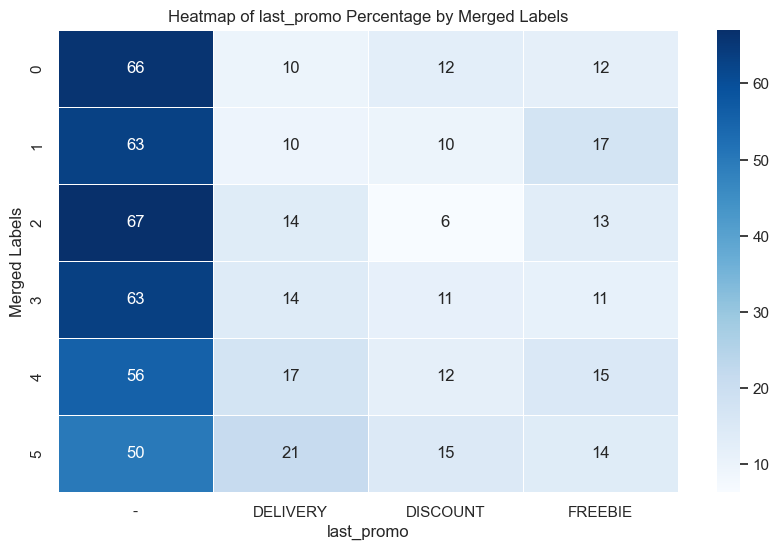

In [208]:
# Group by merged_labels and last_promo
df_cl_promo = df_hc.groupby(['merged_labels', 'last_promo'])['last_promo'].size().unstack()

# Calculate the percentage distribution
df_cl_promo_pct = df_cl_promo.copy()
for i in df_hc['last_promo'].unique():
    df_cl_promo_pct[i] = 100 * df_cl_promo_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_cl_promo_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5)
plt.title('Heatmap of last_promo Percentage by Merged Labels')
plt.xlabel('last_promo')
plt.ylabel('Merged Labels')
plt.show()

In [209]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [210]:
calinski_harabasz_score(df_hc[metric_features], df_hc['merged_labels'])

3499.6433247998443

In [211]:
get_r2_score(df_hc[metric_features + ['merged_labels']],'merged_labels')

0.35595603396911196

In [212]:
# We are essentially decomposing the R² into the R² for each variable
r2_variables(df_hc[metric_features + ['merged_labels']], 'merged_labels').drop('merged_labels')

total_spent               0.497641
avg_spending_per_order    0.139301
last_order                0.086160
Weekdays                  0.559331
chain_order_ratio         0.011069
HR_breakfast              0.273635
HR_lunch_dinner           0.306609
HR_afternoon              0.342317
HR_evening                0.554675
Western_Cuisine           0.144468
Asian_Cuisine             0.280004
Complementary_Cuisine     0.476914
Other_Cuisines            0.275073
dtype: float64

In [213]:
# Preparing the data
X = df_hc[metric_features]
y = df_hc.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 92.72% of the customers correctly


In [214]:
pd.Series(dt.feature_importances_, index=X_train.columns).to_frame(name='Importance')

,Importance
total_spent,0.461571
avg_spending_per_order,0.000000
last_order,0.000000
Weekdays,0.227334
chain_order_ratio,0.000000
HR_breakfast,0.000000
HR_lunch_dinner,0.006737
HR_afternoon,0.000000
HR_evening,0.291945
Western_Cuisine,0.000000


<a class="anchor" id="3rd-bullet">

### TSNE ALL metric features
</a>

In [215]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=42, perplexity=12).fit_transform(df_hc[metric_features])


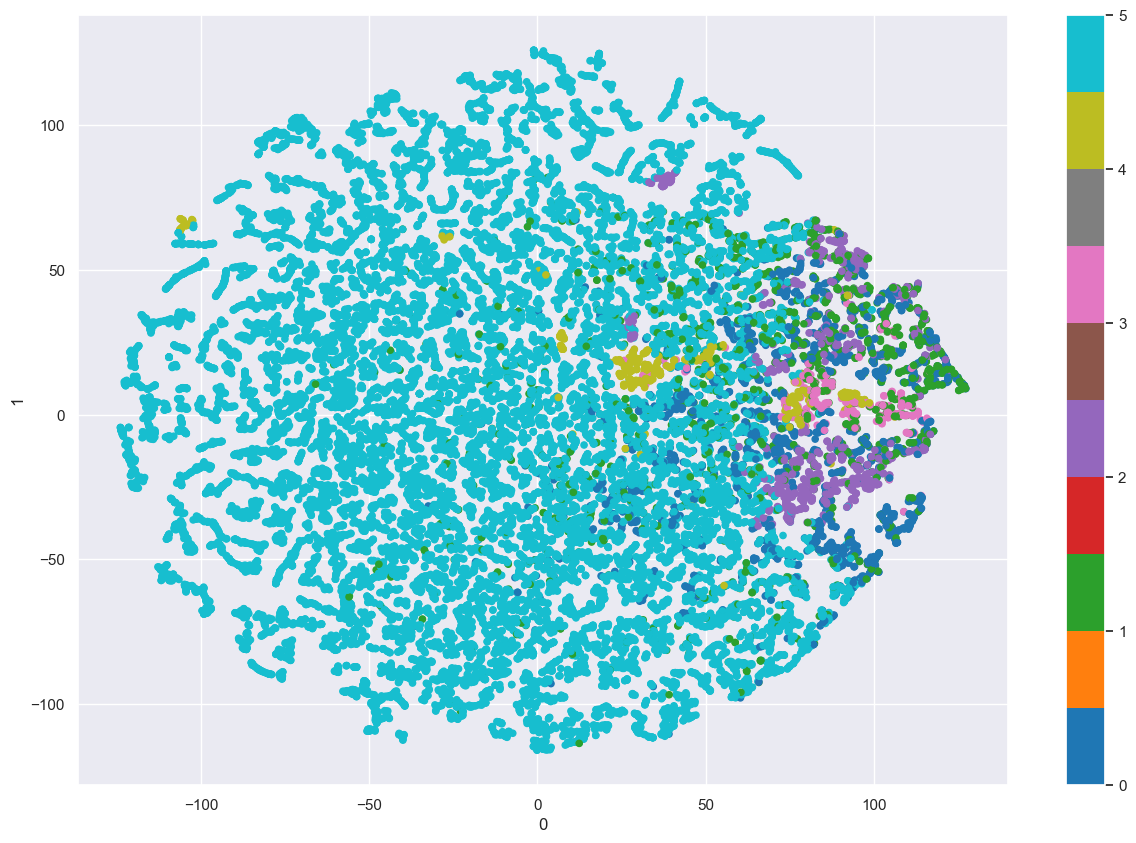

In [216]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_hc['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

<div class="alert alert-block alert-success">

<a class="anchor" id="1st-bullet">    </a>
## 4. Hierarchical Clustering from the beggining
    


</div>

<a class="anchor" id="3rd-bullet">

### Value perspetive
</a>

In [82]:
df_value_hc = df_value.copy()

In [83]:
df_value_hc.head()

,total_spent,avg_spending_per_order,last_order
0,-0.209739,0.528655,-2.706721
1,-0.427887,-0.088755,-2.706721
2,-0.653705,-0.727873,-2.706721
3,-0.149281,0.699767,-2.663582
4,0.389434,2.224456,-2.663582


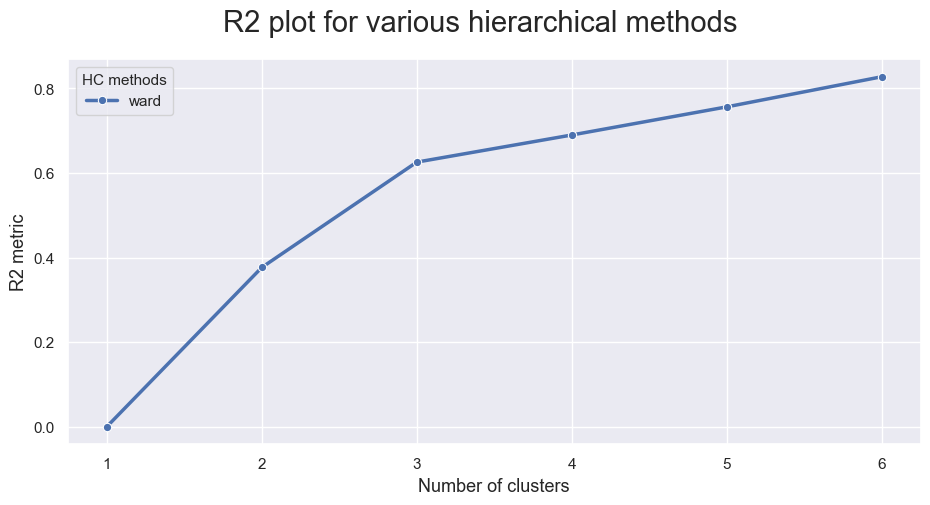

In [108]:
hierarchical_clustering_methods_nclust_analysis(df_value_hc, ["ward"], 6)

Optimal Number of Clusters = ?


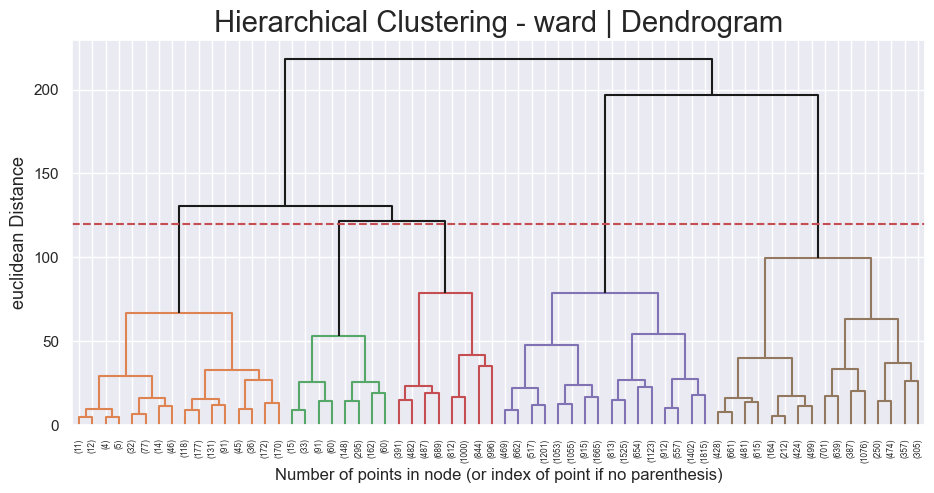

In [85]:
plot_dendrogram(dataframe=df_value_hc, y_threshold= 120, linkage="ward", metric='euclidean')

Optimal Number of Clusters = 4

In [110]:
hclust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=4)
df_value_hc['value_labels'] =  hclust.fit_predict(df_value_hc)
df_centroids = df_value_hc.groupby('value_labels').mean()

# Apply gradient styling to the DataFrame
df_styled = df_centroids.style.background_gradient(cmap='Blues', axis=0)
df_styled

,total_spent,avg_spending_per_order,last_order
value_labels,,,
0,0.708620,0.784540,0.619820
1,-0.392649,0.232955,-1.427306
2,-0.356045,-0.477855,0.363750
3,3.661492,0.761813,0.823526


In [111]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_value_hc)  # get total sum of squares
ssw_labels = df_value_hc[value_perspetive + ["value_labels"]].groupby(by='value_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.632618672777253

<a class="anchor" id="3rd-bullet">

### Preference Based Features
</a>


In [87]:
df_prf_hc = df_prf.copy()

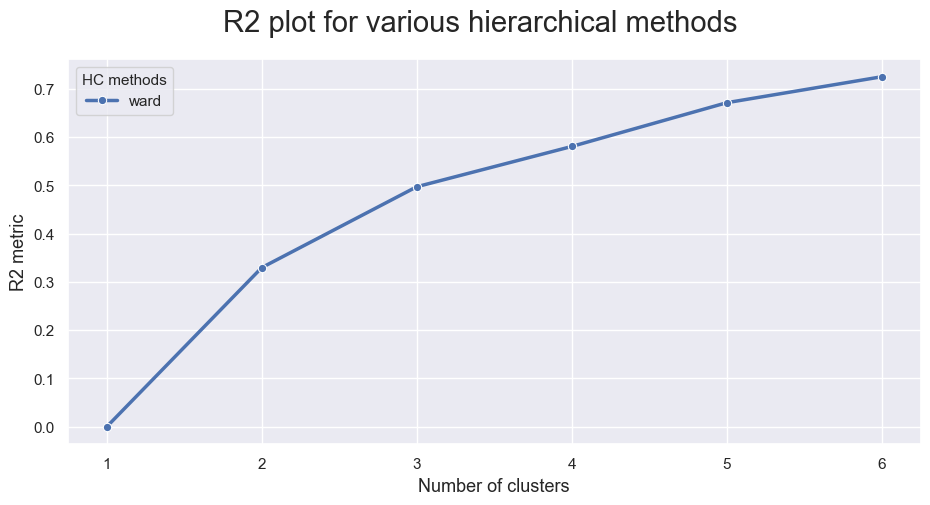

In [112]:
hierarchical_clustering_methods_nclust_analysis(df_prf_hc, ["ward"], 6)

In [113]:
hclust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5)
df_prf_hc['preference_labels'] =  hclust.fit_predict(df_prf_hc)
df_centroids = df_prf_hc.groupby('preference_labels').mean()

# Apply gradient styling to the DataFrame
df_styled = df_centroids.style.background_gradient(cmap='Blues', axis=0)
df_styled

,Western_Cuisine,Asian_Cuisine,Complementary_Cuisine,Other_Cuisines
preference_labels,,,,
0,-0.284307,-0.218989,1.157056,-0.161666
1,0.063656,-0.094767,-0.097805,2.203125
2,-0.110669,-0.166704,-0.333383,-0.254392
3,3.741621,0.214457,0.086950,-0.118735
4,-0.117570,3.039439,0.255158,0.194151


In [114]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_prf_hc)  # get total sum of squares
ssw_labels = df_prf_hc[preference_features + ["preference_labels"]].groupby(by='preference_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.5455872616039648

<a class="anchor" id="3rd-bullet">

### Behaviour Based Features
</a>


In [90]:
df_beh_hc = df_beh.copy()

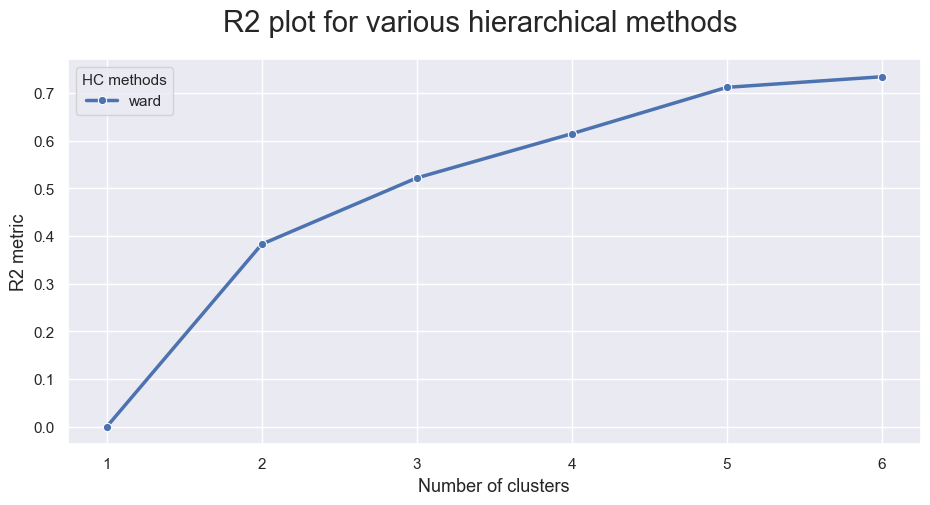

In [115]:
hierarchical_clustering_methods_nclust_analysis(df_beh_hc, ["ward"], 6)

- The ward linkage is the one that performed better getting higher values in R^2 and the distance that will be used is euclidean

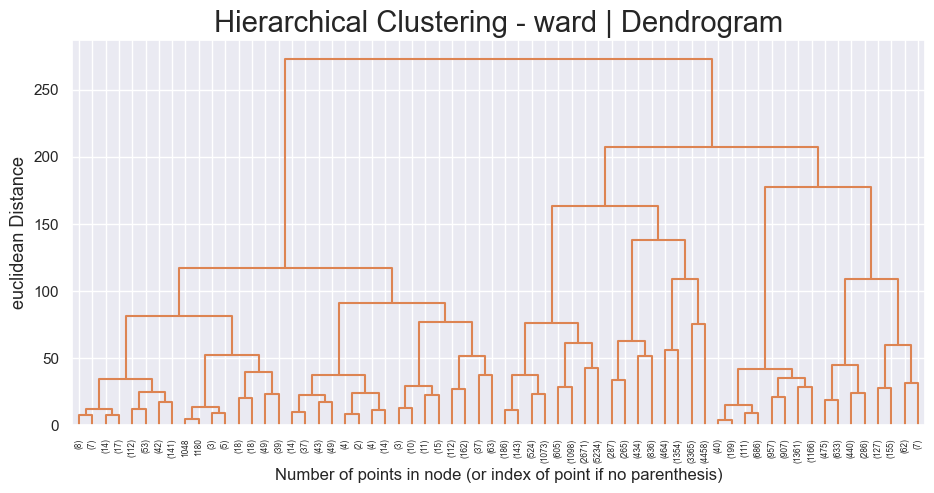

In [92]:
plot_dendrogram(dataframe=df_beh_hc, y_threshold=2400, linkage="ward", metric='euclidean')

In [116]:
hclust_beh = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5)
df_beh_hc['behaviour_labels'] =  hclust_beh.fit_predict(df_beh_hc)
df_centroids = df_beh_hc.groupby('behaviour_labels').mean()

# Apply gradient styling to the DataFrame
df_styled = df_centroids.style.background_gradient(cmap='Blues', axis=0)
df_styled

,Weekdays,chain_order_ratio,HR_breakfast,HR_lunch_dinner,HR_afternoon,HR_evening
behaviour_labels,,,,,,
0,0.240932,-0.128118,0.261766,0.051213,0.329042,-0.195294
1,3.482359,0.233346,2.352793,3.185712,2.149749,0.181720
2,-0.392771,0.941848,-0.319147,-0.127431,-0.301927,-0.209706
3,0.324100,-0.396688,0.026741,-0.287532,-0.486718,2.566526
4,-0.515606,-1.619025,-0.365746,-0.371987,-0.296265,-0.212235


In [117]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_beh_hc)  # get total sum of squares
ssw_labels = df_beh_hc[behaviour_features + ["behaviour_labels"]].groupby(by='behaviour_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.6018595543321912

<a class="anchor" id="3rd-bullet">

### MERGED HC Perspetives
</a>

In [118]:
df["value_labels"] = df_value_hc["value_labels"]
df["preference_labels"] = df_prf_hc["preference_labels"]
df["behaviour_labels"] = df_beh_hc["behaviour_labels"]

In [119]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['value_labels', 'preference_labels', 'behaviour_labels'])\
    [metric_features].mean()
df_centroids

total_spent  \
value_labels preference_labels behaviour_labels                
0            0                 0                    0.753268   
                               1                    1.454852   
                               2                    0.188123   
                               3                    0.887209   
                               4                    0.005203   
...                                                      ...   
3            4                 0                    2.991969   
                               1                    5.314940   
                               2                    1.901194   
                               3                    3.425412   
                               4                    1.950196   

                                                 avg_spending_per_order  \
value_labels preference_labels behaviour_labels                           
0            0                 0                               0.291529   
                               1                              -0.681689   
                               2                               1.408173   
                               3                               0.597197   
                               4                               1.790988   
...                                                                 ...   
3            4                 0                               1.034507   
                               1                               0.066288   
                               2                               1.191277   
                               3                               1.064082   
                               4                               1.573824   

                                                 last_order  Weekdays  \
value_labels preference_labels behaviour_labels                         
0            0                 0                   0.708859  0.548367   
                               1                   0.917629  3.560281   
                               2                   0.553629 -0.335835   
                               3                   0.682266  0.326172   
                               4                   0.455794 -0.527935   
...                                                     ...       ...   
3            4                 0                   0.805890  1.069000   
                               1                   0.934689  4.758255   
                               2                   0.550269  0.407479   
                               3                   0.768466  1.284100   
                               4                   0.960089 -0.027230   

                                                 chain_order_ratio  \
value_labels preference_labels behaviour_labels                      
0            0                 0                         -0.025602   
                               1                          0.511391   
                               2                          0.866367   
                               3                         -0.262789   
                               4                         -1.619510   
...                                                            ...   
3            4                 0                         -0.466954   
                               1                         -0.211781   
                               2                          0.511264   
                               3                         -0.523213   
                               4                         -1.619510   

                                                 HR_breakfast  \
value_labels preference_labels behaviour_labels                 
0            0                 0                     0.979074   
                               1                     2.662767   
                               2                    -0.110202   
                               3                     0

In [120]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids)

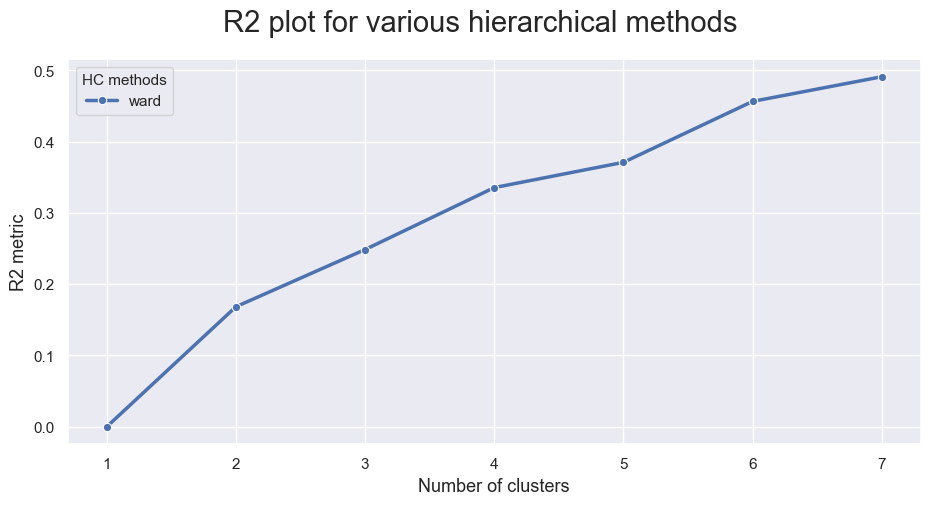

In [121]:
hierarchical_clustering_methods_nclust_analysis(df[metric_features], ["ward"], 7)

In [122]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=6
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

total_spent  \
value_labels preference_labels behaviour_labels                
0            0                 0                    0.753268   
                               1                    1.454852   
                               2                    0.188123   
                               3                    0.887209   
                               4                    0.005203   
...                                                      ...   
3            4                 0                    2.991969   
                               1                    5.314940   
                               2                    1.901194   
                               3                    3.425412   
                               4                    1.950196   

                                                 avg_spending_per_order  \
value_labels preference_labels behaviour_labels                           
0            0                 0                               0.291529   
                               1                              -0.681689   
                               2                               1.408173   
                               3                               0.597197   
                               4                               1.790988   
...                                                                 ...   
3            4                 0                               1.034507   
                               1                               0.066288   
                               2                               1.191277   
                               3                               1.064082   
                               4                               1.573824   

                                                 last_order  Weekdays  \
value_labels preference_labels behaviour_labels                         
0            0                 0                   0.708859  0.548367   
                               1                   0.917629  3.560281   
                               2                   0.553629 -0.335835   
                               3                   0.682266  0.326172   
                               4                   0.455794 -0.527935   
...                                                     ...       ...   
3            4                 0                   0.805890  1.069000   
                               1                   0.934689  4.758255   
                               2                   0.550269  0.407479   
                               3                   0.768466  1.284100   
                               4                   0.960089 -0.027230   

                                                 chain_order_ratio  \
value_labels preference_labels behaviour_labels                      
0            0                 0                         -0.025602   
                               1                          0.511391   
                               2                          0.866367   
                               3                         -0.262789   
                               4                         -1.619510   
...                                                            ...   
3            4                 0                         -0.466954   
                               1                         -0.211781   
                               2                          0.511264   
                               3                         -0.523213   
                               4                         -1.619510   

                                                 HR_breakfast  \
value_labels preference_labels behaviour_labels                 
0            0                 0                     0.979074   
                               1                     2.662767   
                               2                    -0.110202   
                               3                     0

In [123]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper

{(0, 0, 0): 5,
 (0, 0, 1): 0,
 (0, 0, 2): 5,
 (0, 0, 3): 5,
 (0, 0, 4): 5,
 (0, 1, 0): 5,
 (0, 1, 1): 0,
 (0, 1, 2): 5,
 (0, 1, 3): 5,
 (0, 1, 4): 5,
 (0, 2, 0): 5,
 (0, 2, 1): 0,
 (0, 2, 2): 5,
 (0, 2, 3): 5,
 (0, 2, 4): 5,
 (0, 3, 0): 4,
 (0, 3, 1): 0,
 (0, 3, 2): 4,
 (0, 3, 3): 4,
 (0, 3, 4): 4,
 (0, 4, 0): 2,
 (0, 4, 1): 0,
 (0, 4, 2): 2,
 (0, 4, 3): 2,
 (0, 4, 4): 2,
 (1, 0, 0): 5,
 (1, 0, 1): 0,
 (1, 0, 2): 5,
 (1, 0, 3): 5,
 (1, 0, 4): 5,
 (1, 1, 0): 5,
 (1, 1, 2): 5,
 (1, 1, 3): 5,
 (1, 1, 4): 5,
 (1, 2, 0): 5,
 (1, 2, 1): 0,
 (1, 2, 2): 5,
 (1, 2, 3): 5,
 (1, 2, 4): 5,
 (1, 3, 0): 4,
 (1, 3, 2): 4,
 (1, 3, 3): 4,
 (1, 3, 4): 4,
 (1, 4, 0): 2,
 (1, 4, 2): 2,
 (1, 4, 3): 2,
 (1, 4, 4): 2,
 (2, 0, 0): 5,
 (2, 0, 1): 0,
 (2, 0, 2): 5,
 (2, 0, 3): 5,
 (2, 0, 4): 5,
 (2, 1, 0): 5,
 (2, 1, 1): 0,
 (2, 1, 2): 5,
 (2, 1, 3): 5,
 (2, 1, 4): 5,
 (2, 2, 0): 5,
 (2, 2, 1): 0,
 (2, 2, 2): 5,
 (2, 2, 3): 5,
 (2, 2, 4): 5,
 (2, 3, 0): 4,
 (2, 3, 1): 0,
 (2, 3, 2): 4,
 (2, 3, 3): 4,
 (2, 3, 4)

In [124]:
df_hc = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_hc['merged_labels'] = df_hc.apply(
    lambda row: cluster_mapper[
        (row['value_labels'], row['preference_labels'], row['behaviour_labels'])
    ], axis=1
)

df_hc

,customer_region,customer_age,vendor_count,product_count,is_chain,first_order,last_order,last_promo,payment_method,CUI_American,...,avg_spending_per_order,chain_order_ratio,preferred_cui,preferred_cui_type,value_labels,prf_labels,beh_labels,preference_labels,behaviour_labels,merged_labels
0,2360,-1.337468,-0.405436,-0.098281,-0.475544,-1.175717,-2.706721,DELIVERY,DIGI,-0.422050,...,0.528655,-0.327866,CUI_Indian,Asian_Cuisine,1,2,0,2,0,5
1,8670,-1.478630,-0.405436,-0.555346,-0.212185,-1.175717,-2.706721,DISCOUNT,DIGI,0.686724,...,-0.088755,0.963778,CUI_American,Western_Cuisine,1,2,2,2,2,5
2,4660,1.485773,-0.771607,-0.555346,-0.212185,-1.175717,-2.706721,DISCOUNT,CASH,0.373638,...,-0.727873,0.963778,CUI_American,Western_Cuisine,1,2,2,2,2,5
3,4660,-0.208171,-0.405436,-0.402991,-0.475544,-1.175717,-2.663582,DELIVERY,DIGI,-0.422050,...,0.699767,-0.327866,CUI_Indian,Asian_Cuisine,1,2,0,2,0,5
4,4660,-1.055144,-0.405436,-0.098281,-0.738902,-1.175717,-2.663582,-,DIGI,0.838078,...,2.224456,-1.619510,CUI_Asian,Asian_Cuisine,1,2,0,2,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31712,8670,0.356477,-0.771607,-0.707701,-0.475544,-1.175717,-2.749860,FREEBIE,DIGI,-0.422050,...,0.988360,0.963778,CUI_Beverages,Complementary_Cuisine,1,2,2,0,2,5
31713,8670,-0.208171,-0.771607,-0.707701,-0.738902,-1.175717,-2.749860,DELIVERY,DIGI,1.138191,...,0.988360,-1.619510,CUI_American,Western_Cuisine,1,2,0,2,4,5
31714,8670,-0.490496,-0.771607,-0.707701,-0.475544,-1.175717,-2.749860,-,DIGI,-0.422050,...,0.956436,0.963778,CUI_Desserts,Complementary_Cuisine,1,2,2,0,2,5
31715,8670,0.921125,-0.771607,-0.707701,-0.738902,-1.175717,-2.749860,DISCOUNT,DIGI,-0.422050,...,0.220908,-1.619510,CUI_Asian,Asian_Cuisine,1,2,0,2,4,5


In [125]:
df_hc['merged_labels'].value_counts()

merged_labels
5    28117
2     1350
0     1048
4      840
3      209
1      153
Name: count, dtype: int64

In [126]:
get_r2_score(df_hc[metric_features + ['merged_labels']],'merged_labels')

0.3354126687621103

In [127]:
calinski_harabasz_score(df_hc[metric_features], df_hc['merged_labels'])

2384.975358142048

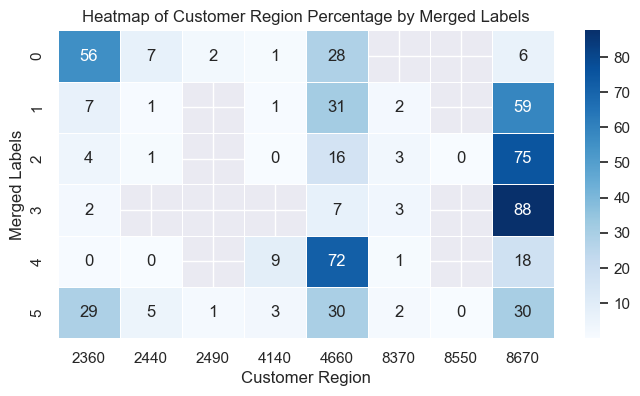

In [130]:
# Group by merged_labels and customer_region
df_cl_region = df_hc.groupby(['merged_labels', 'customer_region'])['customer_region'].size().unstack()

# Calculate the percentage distribution
df_cl_region_pct = df_cl_region.copy()
for i in df_hc['customer_region'].unique():
    df_cl_region_pct[i] = 100 * df_cl_region_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_cl_region_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5)
plt.title('Heatmap of Customer Region Percentage by Merged Labels')
plt.xlabel('Customer Region')
plt.ylabel('Merged Labels')
plt.show()

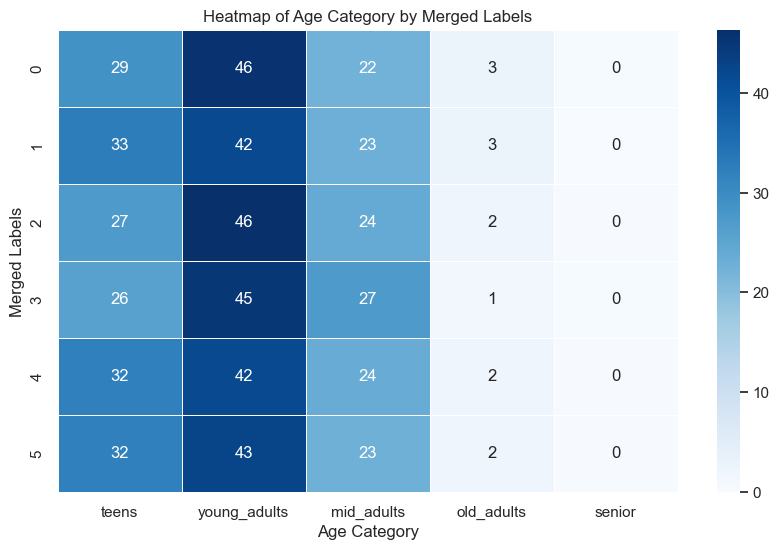

In [131]:
# Group by merged_labels and age_category
# Define the order of age categories from youngest to oldest
age_order = ['teens', 'young_adults', 'mid_adults', 'old_adults', 'senior']
df_hc['age_category'] = pd.Categorical(df_['age_category'], categories=age_order, ordered=True)

df_cl_age = df_hc.groupby(['merged_labels', 'age_category'])['age_category'].size().unstack()

# Reorder the columns based on the defined age order
df_cl_age = df_cl_age[age_order]

# Calculate the percentage distribution
df_cl_age_pct = df_cl_age.copy()
for i in df_hc['age_category'].unique():
    df_cl_age_pct[i] = 100 * df_cl_age_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_cl_age_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5)
plt.title('Heatmap of Age Category by Merged Labels')
plt.xlabel('Age Category')
plt.ylabel('Merged Labels')
plt.show()